In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [15]:
df=pd.read_excel('Motor Trend Car Road Tests.xlsx')

In [16]:
df.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [17]:
X = df.drop(columns=['model', 'mpg']) 
y = df['mpg']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

fitted_vals = model.predict()
residuals = model.resid

Problema 1 - No linealidad.

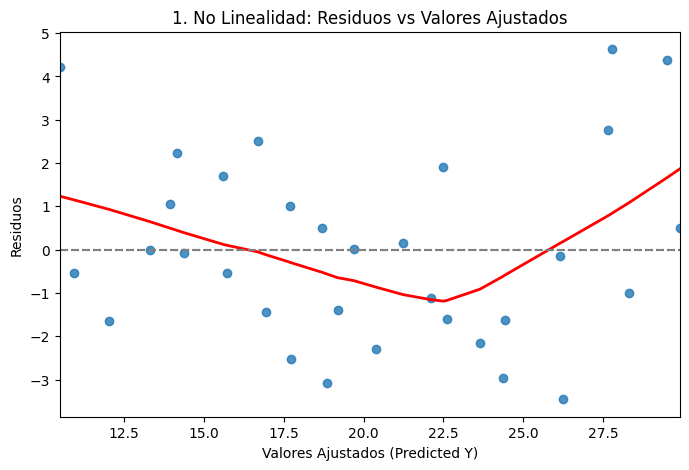

In [20]:
def checar_linealidad(fitted_vals, residuals):
    plt.figure(figsize=(8, 5))
    sns.residplot(x=fitted_vals, y=residuals, lowess=True, 
                  line_kws={'color': 'red', 'lw': 2})
    plt.title('1. No Linealidad: Residuos vs Valores Ajustados')
    plt.xlabel('Valores Ajustados (Predicted Y)')
    plt.ylabel('Residuos')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.show()

checar_linealidad(fitted_vals, residuals)

Como podemos ver en este caso no hay linealidad, ya que los residuos deberían estar distribuidos aleatoriamente alrededor del 0. En nuestra regresión, se observa que este patrón no es lineal y se comporta diferente en diferentes valores ajustados. Se utiliza la línea roja LOWESS (Locally Weighted Scatterplot Smoothing) que son miles de pequeñas regresiones en cada segmento del gráfico para mostrar la tendencia en ese punto, así se puede observar claramente si el patrón es diferente de estar centrado en 0.

# 2) Correlación de errores.

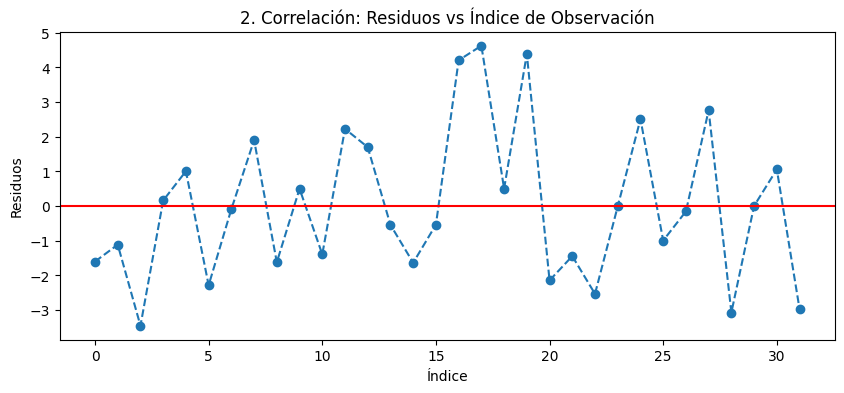

In [24]:
def check_error_correlation(residuals):
    plt.figure(figsize=(10, 4))
    plt.plot(residuals.index, residuals, marker='o', linestyle='--')
    plt.title('2. Correlación: Residuos vs Índice de Observación')
    plt.xlabel('Índice')
    plt.ylabel('Residuos')
    plt.axhline(y=0, color='red', linestyle='-')
    plt.show()

check_error_correlation(residuals)

En el libro, se advierte de 'Tracking' que es una correlación positiva, cuando los residuos tienen valores muy similares y en patrón. Los puntos aquí siguen un ruido blanco frenético, por lo que se afirma la independencia de los errores.

# 3) Homocedasticidad en errores.

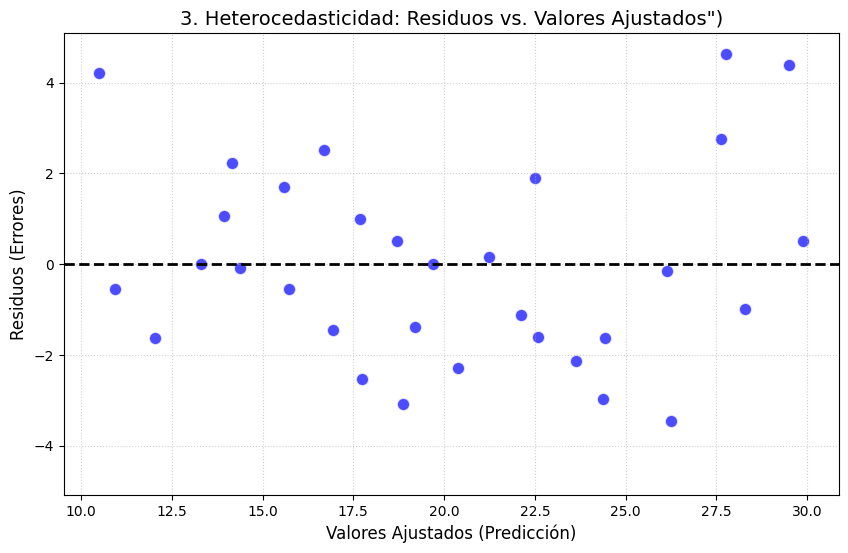

In [28]:
def check_heteroscedasticity_funnel(fitted_vals, residuals):
    plt.figure(figsize=(10, 6))
    

    plt.scatter(fitted_vals, residuals, alpha=0.7, c='blue', edgecolors='w', s=80)
 
    plt.axhline(y=0, color='black', linestyle='--', linewidth=2)
    

    plt.title('3. Heterocedasticidad: Residuos vs. Valores Ajustados")', fontsize=14)
    plt.xlabel('Valores Ajustados (Predicción)', fontsize=12)
    plt.ylabel('Residuos (Errores)', fontsize=12)
    

    max_resid = np.max(np.abs(residuals))
    plt.ylim(-max_resid * 1.1, max_resid * 1.1)
    
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

check_heteroscedasticity_funnel(fitted_vals, residuals)

En este caso, podemos ver que la varianza no es plana y constante, cuando la regresión lineal asume que la varianza de los errores sí es constante.

# 4) Outliers.

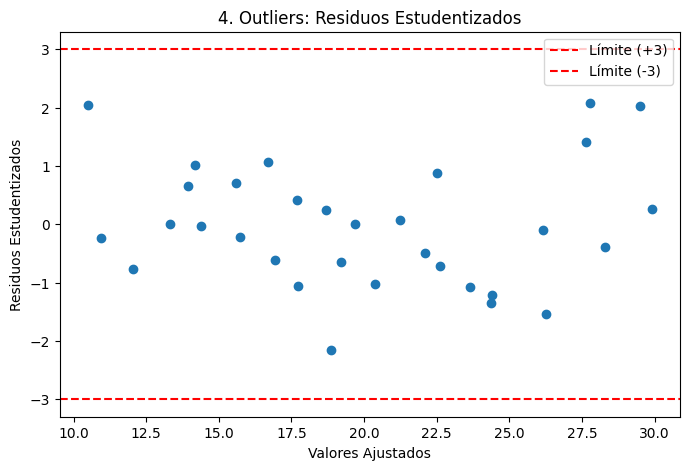

In [29]:

def check_outliers(model):

    student_residuals = model.get_influence().resid_studentized_external
    
    plt.figure(figsize=(8, 5))
    plt.scatter(model.fittedvalues, student_residuals)
    plt.axhline(y=3, color='red', linestyle='--', label='Límite (+3)')
    plt.axhline(y=-3, color='red', linestyle='--', label='Límite (-3)')
    plt.title('4. Outliers: Residuos Estudentizados')
    plt.xlabel('Valores Ajustados')
    plt.ylabel('Residuos Estudentizados')
    plt.legend()
    plt.show()

check_outliers(model)

Como podemos ver en la gráfica, no existen outliers utilizando +-3 desviaciones estándar.

# 5) Puntos Palanca.

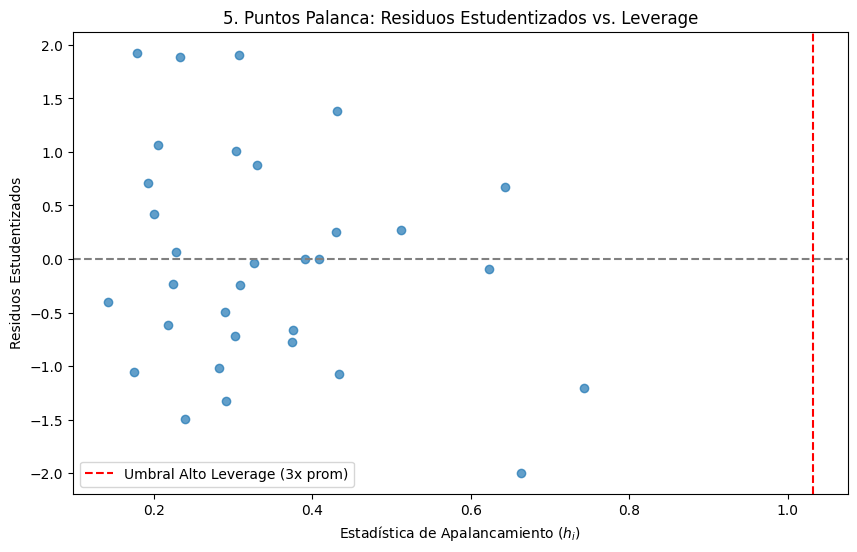

In [32]:

from statsmodels.graphics.regressionplots import plot_leverage_resid2

def check_leverage_graph(model):
    
    influence = model.get_influence()
    leverage = influence.hat_matrix_diag
    studentized_residuals = influence.resid_studentized_internal

    n = len(leverage)
    p = model.df_model + 1 
    avg_leverage = p / n
    
    plt.figure(figsize=(10, 6))
    plt.scatter(leverage, studentized_residuals, alpha=0.7)
    
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.axvline(x=avg_leverage * 3, color='red', linestyle='--', label='Umbral Alto Leverage (3x prom)')
    
    plt.title('5. Puntos Palanca: Residuos Estudentizados vs. Leverage')
    plt.xlabel('Estadística de Apalancamiento ($h_i$)')
    plt.ylabel('Residuos Estudentizados')
    plt.legend()
    for i, (x, y) in enumerate(zip(leverage, studentized_residuals)):
        if x > avg_leverage * 3 or abs(y) > 3:
            plt.text(x, y, str(i), fontsize=9, color='red')
            
    plt.show()

check_leverage_graph(model)

Como podemos ver, no hay puntos palanca, el apalancamiento mide qué tan inusuales son cada X de todo el conjunto. Como podemos ver no hay ningñun punto que tenga un residuo alto y tampoco una observación X inusual.

# 6) Colinealidad.

In [37]:


def check_collinearity_manual(X):
    results = []
    variables = [col for col in X.columns if col != 'const']
    
    print(f"{'Variable':<15} | {'R^2 Auxiliar':<12} | {'VIF':<10}")
    print("-" * 45)
    
    for var in variables:
        y_aux = X[var]
        X_aux = X.drop(columns=[var]) 
        
        model_aux = sm.OLS(y_aux, X_aux).fit()
        
        r_sq = model_aux.rsquared
        
        if r_sq < 1:
            vif = 1 / (1 - r_sq)
        else:
            vif = float('inf')
            
        results.append({'Variable': var, 'R_squared': r_sq, 'VIF': vif})
        print(f"{var:<15} | {r_sq:<12.4f} | {vif:<10.2f}")

    print("-" * 45)


check_collinearity_manual(X)

Variable        | R^2 Auxiliar | VIF       
---------------------------------------------
cyl             | 0.9350       | 15.37     
disp            | 0.9537       | 21.62     
hp              | 0.8983       | 9.83      
drat            | 0.7037       | 3.37      
wt              | 0.9341       | 15.16     
qsec            | 0.8672       | 7.53      
vs              | 0.7986       | 4.97      
am              | 0.7849       | 4.65      
gear            | 0.8133       | 5.36      
carb            | 0.8736       | 7.91      
---------------------------------------------


Como podemos ver, y según el libro, las variables con VIF mayor a 5, se pueden explicar con todas las otras juntas, la estrategia es eliminar poco a poco las variables con VIF más alto, ya que si eliminamos todas las de VIF alto, podrían ser causantes del VIF de alguna otra.